In [1]:
from math import exp, log

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.special import expit

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline 

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
np.random.seed(42)

### Model

Assume we have patients characterized by sex and age suffering from some disease with different severities. The recovery time of a patient depends only on the sex, age, severity and if the patient is on medication. Let the expected recovery time in days $t_{recovery}$ be defined as
$$\mathbf{E}(t_{recovery}) = \exp(2+0.5*I_{male}+0.03*age+2*severity-1*I_{medication}),$$
where $I$ is an indicator function.
Furthermore, we will assume a Poisson distribution in order to generate some synthetic data of our patient's recovery time. Due to our definition, treating the disease with medication reduces the recovery time to $exp(-1)\approx 0.37$ of the recovery time having no treatment. Although the recovery time is specific to each patients, i.e. his/her features, the effect of a reduction to 37% of the recovery time without medication is the same for all patients. 

In [3]:
def exp_recovery_time(sex, age, severity, medication):
    return exp(2+0.5*sex+0.03*age+2*severity-1*medication)

def rvs_recovery_time(sex, age, severity, medication, *args):
    return stats.poisson.rvs(exp_recovery_time(sex, age, severity, medication))

For the features of the patients we will use a Beta distribution to show how badly the disease struck the patients, a Gamma distribution for the age of our patients and a Bernoulli distribution for the gender of the patients.

In [4]:
N = 10000  # number of observations, i.e. patients
sexes = np.random.randint(0,2, size=N)  # sex == 1 if male otherwise female
ages_dist = stats.gamma(8, scale=4)
ages = ages_dist.rvs(size=N)
sev_dist = stats.beta(3, 1.5)
severties = sev_dist.rvs(size=N)

It's always a good idea to take a look at the nontrivial distributions:

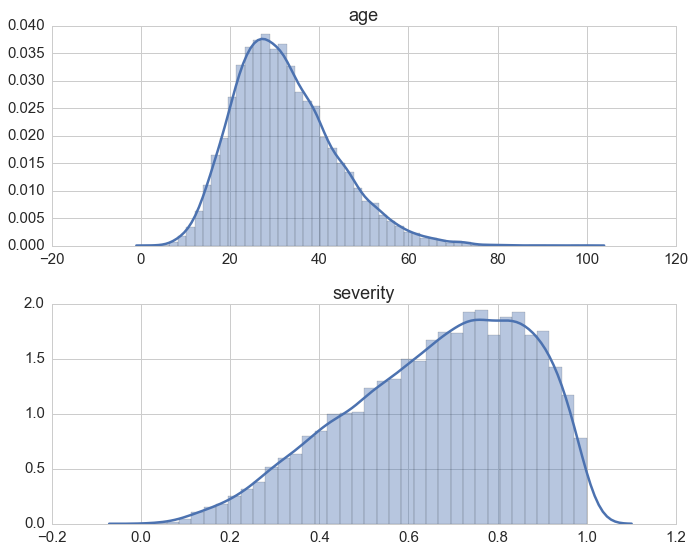

In [5]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('age')
ax2.set_title('severity')
sns.distplot(ages, ax=ax1)
sns.distplot(severties, ax=ax2)
plt.tight_layout();

### Randomized trail

In a controlled randomized trial we randomly select patients and assign them with a chance of 50% to either treatment or control. Therefore, the assignment of treatement is completely random and independent. 

In [6]:
meds = np.random.randint(0, 2, size=N)

We assemble everything in a dataframe also including a constant column.

In [7]:
const = np.ones(N)
df = pd.DataFrame(dict(sex=sexes, age=ages, severity=severties, medication=meds, const=const))
features = ['sex', 'age', 'severity', 'medication', 'const']
df = df[features] # to enforce column order
df['recovery'] = df.apply(lambda x: rvs_recovery_time(*x) , axis=1)
df.head()

,sex,age,severity,medication,const,recovery
0,0,24.518667,0.858950,1,1.0,34
1,1,11.080205,0.905123,0,1.0,97
2,0,37.014895,0.601475,0,1.0,77
3,0,35.657701,0.749840,1,1.0,39
4,0,36.735167,0.385460,1,1.0,18


In [8]:
df.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.497400,1.0,76.085700
std,0.500023,11.243333,0.201010,0.500018,0.0,63.304659
min,0.000000,4.508904,0.029818,0.000000,1.0,0.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,33.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,57.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,99.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,805.000000


By construction, there is no correlation between medication and any other covariate.

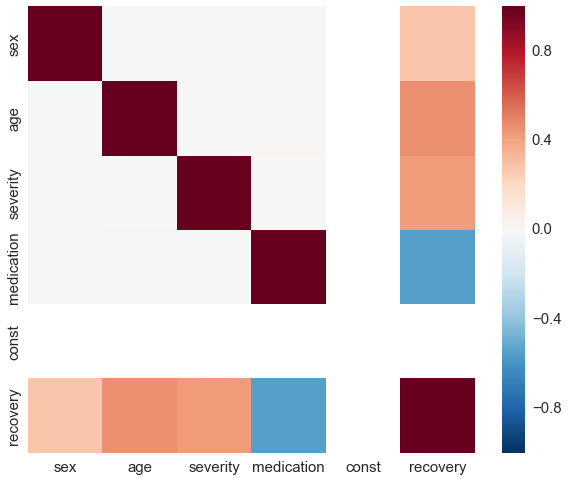

In [9]:
sns.heatmap(df.corr(), vmin=-1, vmax=1);

To get started we use a Poisson regression to estimate the coefficients of our formula for $\mathbf{E}(t_{recovery})$ from the generated data. Of course we expect to see approximately the same coefficients since Poisson regression assumes the exact same model that generated our data.

In [10]:
glm = sm.GLM(df['recovery'], df[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -34429.
Date:                Sat, 25 Mar 2017   Deviance:                       10080.
Time:                        12:22:09   Pearson chi2:                 1.00e+04
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4994      0.002    211.934      0.000       0.495       0.504
age            0.0301   8.95e-05    335.807      0.000       0.030       0.030
severity       2.0000      0.006    309.610      0.000       1.987       2.013
medication    -1.0024      0.003   -387.721      0.000      -1.007      -0.997
const          1.9990      0.006    326.234      0.000       1.987       2.011
==============================================================================
"""

Now we use a randome forest which is a pretty standard machine learning method to estimate the individual effects of the treatment on the patients. We fit the model and predict for each patient the recovery time assuming medication, i.e. medication column is 1, as well as assuming no medication, i.e. medication column is 0. Subsequently we divide the prediction assuming medication by the prediction assuming no medication to get an estimation of the treatment's effect.

In [11]:
reg = RandomForestRegressor()
X = df[features].as_matrix()
y = df['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [12]:
X_neg = np.copy(X)
# set the medication column to 0
X_neg[:, df.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
# set the medication column to 1
X_pos[:, df.columns.get_loc('medication')] = 1

preds_rnd = reg.predict(X_pos) / reg.predict(X_neg)

Let's take a look at the distribution of individual effects. Even though we are assuming no model by using a random forest, our estimations of the treatment effect look decent.

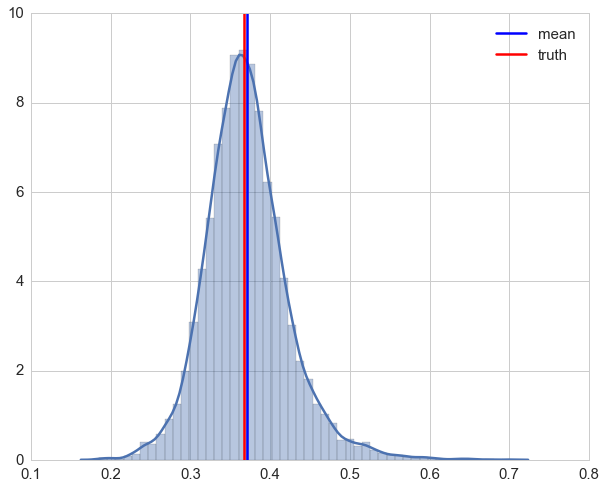

In [13]:
sns.distplot(preds_rnd)
plt.axvline(np.mean(preds_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

### Nonrandomized trail

To make things a bit more interesting, we put now patients on a treatment depending on their sex and severity of the illness. Since men often suffer more than women from the same illness, e.g. man-flu, they tend to complain more and thus are more likely to convince the doctor of prescibing a medication. Thereafter we generate the recovery time again and follow the same procedure as before in the randomized trail.

In [14]:
def get_medication(sex, age, severity, medication, *args):
    return int(1/3*sex + 2/3*severity + 0.15*np.random.randn() > 0.8)

In [15]:
df2 = df.copy().drop('recovery', axis=1)
df2['medication'] = df2.apply(lambda x: get_medication(*x), axis=1)
df2['recovery'] = df2.apply(lambda x: rvs_recovery_time(*x), axis=1)
df2.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000


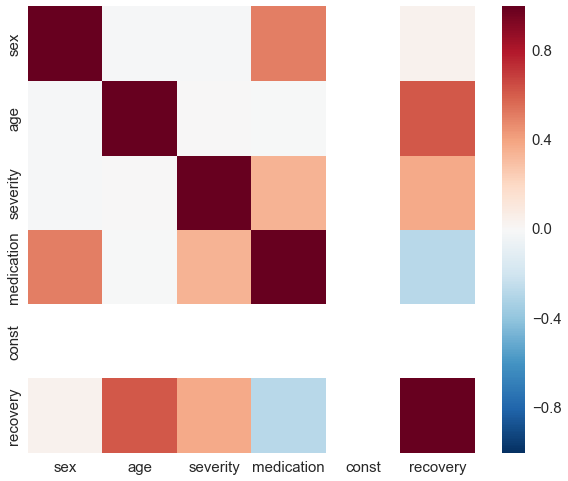

In [16]:
sns.heatmap(df2.corr(), vmin=-1, vmax=1);

In [17]:
glm = sm.GLM(df2['recovery'], df2[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -35645.
Date:                Sat, 25 Mar 2017   Deviance:                       10018.
Time:                        12:22:11   Pearson chi2:                 9.98e+03
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5043      0.002    203.256      0.000       0.499       0.509
age            0.0299   8.58e-05    349.024      0.000       0.030       0.030
severity       1.9996      0.006    313.055      0.000       1.987       2.012
medication    -1.0063      0.003   -302.201      0.000      -1.013      -1.000
const          2.0013      0.006    340.305      0.000       1.990       2.013
==============================================================================
"""

The first stunning result is that the Poisson regression is still able to correctly estimate the coefficients of our model. This is due to the [model dependence](http://www.preventionresearch.org/wp-content/uploads/2011/07/SPR-Propensity-pc-workshop-slides.pdf) and in realistic cases actually a bad thing. The assumptions about the relation of the covariates in the Poisson regression extrapolates our data and thus makes our results heavily depend on the Poisson model. Since we also used a Poisson model to generate the data we are lucky but this is in reality rarely the case. Let's check how the random forest performs.

In [18]:
reg = RandomForestRegressor()
X2 = df2[features].as_matrix()
y2 = df2['recovery'].values
reg.fit(X2, y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [19]:
X2_neg = np.copy(X2)
X2_neg[:, df.columns.get_loc('medication')] = 0
X2_pos = np.copy(X2)
X2_pos[:, df.columns.get_loc('medication')] = 1

preds_no_rnd = reg.predict(X2_pos) / reg.predict(X2_neg)

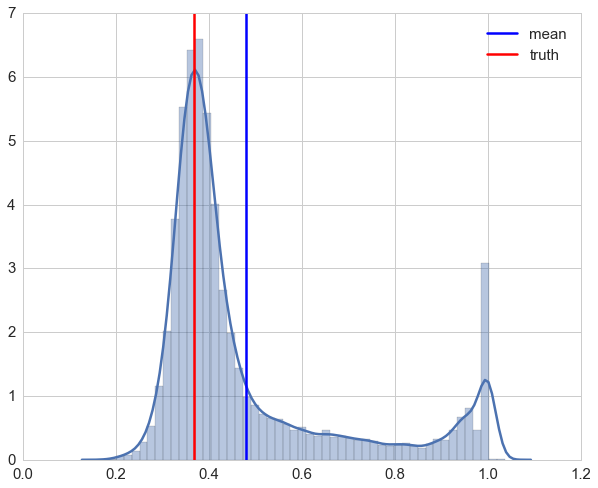

In [20]:
sns.distplot(preds_no_rnd)
plt.axvline(np.mean(preds_no_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

The distribution is now quite skewed and we can see that for a lot of our patients their individual treatment effect is heavily underestimated.

### Inverse probability of treatment weighting

To deminish the impact of other covariates onto the effect of medication we will no calculate the propensity score and use inverse probability of treatment weighting (IPTW). In order to do that we use a classification to predict the probability of a patient to be treated. This can be accomplished by Scikit-Learn's `predict_proba` method that is available for most classificators. Don't be fooled by the name though, in most cases (logistic regression is an exception) the probabilites are not calibrated and cannot be relied on. To fix this, we use the [CalibratedClassifierCV](http://scikit-learn.org/stable/modules/calibration.html) in order to get proper probabilities. After that we calculate the inverse probability of treatment weights and pass those as sample weights to the estimator during the fit.

In [21]:
# classifier to estimate the propensity score
cls = LogisticRegression(random_state=42)
#cls = GaussianNB()

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X3 = df2[features].drop(['medication'], axis=1).as_matrix()
y3 = df2['medication'].values
cls.fit(X3, y3)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [22]:
propensity = pd.DataFrame(cls.predict_proba(X3))
propensity.head()

,0,1
0,0.947430,0.052570
1,0.170632,0.829368
2,0.992034,0.007966
3,0.975970,0.024030
4,0.998434,0.001566


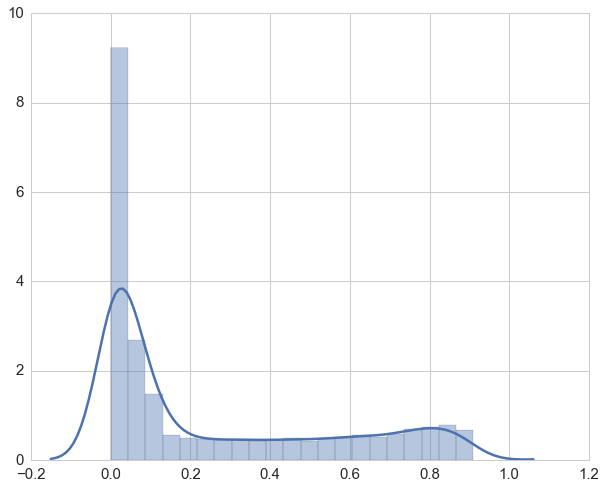

In [23]:
sns.distplot(propensity[1].values);

At this point the inverse probability of treatment weights (IPTWs) are calculated.

In [24]:
df2['iptw'] = 1. / propensity.lookup(np.arange(propensity.shape[0]), df2['medication'])

In [25]:
df2.describe()

,sex,age,severity,medication,const,recovery,iptw
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100,1.860499
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825,4.455724
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000,1.000105
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000,1.016131
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000,1.093217
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000,1.449351
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000,184.561863


The poisson regression benefits by using the IPTWs as weights since the Z-scores of the coefficients increase.

In [26]:
glm = sm.GLM(df2['recovery'], df2[features], 
             family=sm.families.Poisson(),
             freq_weights=df2['iptw'] )
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                    18599
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -64795.
Date:                Sat, 25 Mar 2017   Deviance:                       18482.
Time:                        12:22:13   Pearson chi2:                 1.83e+04
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5018      0.002    294.822      0.000       0.498       0.505
age            0.0298   6.56e-05    454.701      0.000       0.030       0.030
severity       2.0016      0.005    429.319      0.000       1.992       2.011
medication    -1.0017      0.002   -534.776      0.000      -1.005      -0.998
const          2.0055      0.005    441.204      0.000       1.997       2.014
==============================================================================
"""

Let's check how our random forest does with the help of IPTWs.

In [27]:
reg = RandomForestRegressor(random_state=42)
X4 = df2[features].as_matrix()
y4 = df2['recovery'].values
reg.fit(X4, y4, sample_weight=df2['iptw'].values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [28]:
X4_neg = np.copy(X4)
X4_neg[:, df.columns.get_loc('medication')] = 0
X4_pos = np.copy(X4)
X4_pos[:, df.columns.get_loc('medication')] = 1

preds_propensity = reg.predict(X4_pos) / reg.predict(X4_neg)

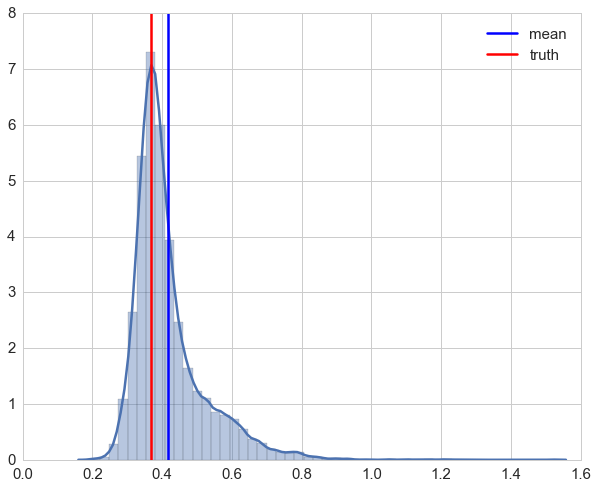

In [29]:
sns.distplot(preds_propensity)
plt.axvline(np.mean(preds_propensity), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

After taking a brief look at the distribution we see that using IPTW drastically improved the estimation of the treatment's causal effect. 

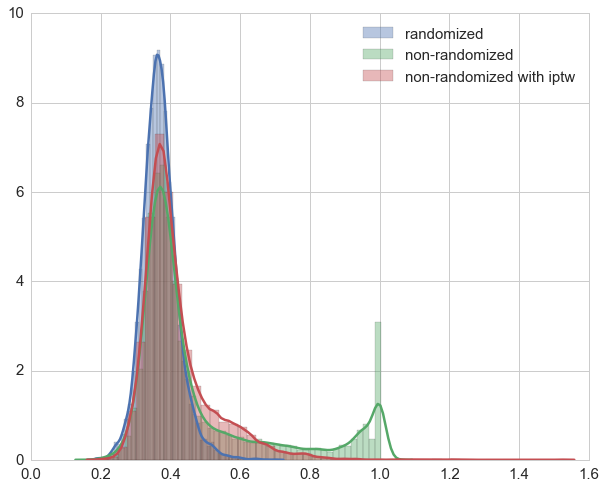

In [30]:
sns.distplot(preds_rnd, label='randomized')
sns.distplot(preds_no_rnd, label='non-randomized')
sns.distplot(preds_propensity, label='non-randomized with iptw')
plt.legend();

The actual trick of IPTW is that sample weights are chosen in such a way that the correlation of other covariates and the medication is decreased. With the help of a weighted correlation this can also be illustrated. Remarkably enough, neither Numpy nor Scipy seem to provide a weigthed correlation function, only weighted covariance, which we use to define a weighted correlation.

In [31]:
def weighted_corr(m, w=None):
    if w is None:
        w = np.ones(m.shape[0])
    cov = np.cov(m, rowvar=False, aweights=w, ddof=0)
    sigma = np.sqrt(np.diag(cov))
    return cov / np.outer(sigma, sigma)

Here is the original correlation of the nonrandomized trail again by setting all weights to 1.

In [32]:
sel_cols = [col for col in df2.columns if col != 'iptw']
orig_corr = weighted_corr(df2[sel_cols].as_matrix(), w=np.ones(df2.shape[0]))
orig_corr = pd.DataFrame(orig_corr, index=sel_cols, columns=sel_cols)
orig_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.013332,-0.012855,0.509914,NaN,0.046250
age,-0.013332,1.000000,0.005086,-0.002818,NaN,0.622472
severity,-0.012855,0.005086,1.000000,0.348317,NaN,0.378225
medication,0.509914,-0.002818,0.348317,1.000000,NaN,-0.276164
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.046250,0.622472,0.378225,-0.276164,NaN,1.000000


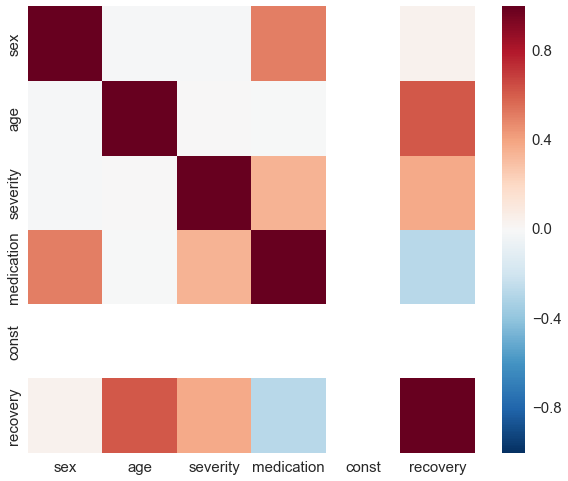

In [33]:
sns.heatmap(orig_corr, vmin=-1, vmax=1);

Using the IPTWs the correlation reduces quite a bit.

In [34]:
iptw_corr = weighted_corr(df2[sel_cols].as_matrix(), w=df2['iptw'].values)
iptw_corr = pd.DataFrame(iptw_corr, index=sel_cols, columns=sel_cols)
iptw_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.001601,-0.154496,0.087948,NaN,0.222515
age,-0.001601,1.000000,-0.028975,0.014248,NaN,0.461467
severity,-0.154496,-0.028975,1.000000,0.103541,NaN,0.369249
medication,0.087948,0.014248,0.103541,1.000000,NaN,-0.531669
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.222515,0.461467,0.369249,-0.531669,NaN,1.000000


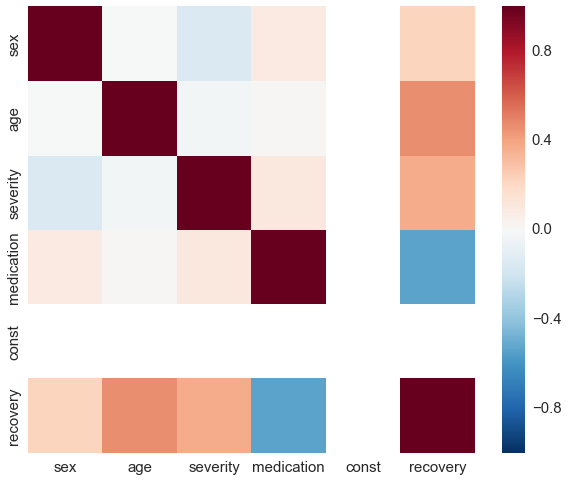

In [35]:
sns.heatmap(iptw_corr, vmin=-1, vmax=1);